<h1>DSCI-552 Homework 5</h1>
<br>
<font size="4">Morgan Gautho | GitHub: morgangauth | 3944-8632-72</font>
    

In [270]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import math
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import scale 
import sys
!{sys.executable} -m pip install xgboost
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## 1. Decision Trees as Interpretable Models

#### (a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.

In [271]:
diagnosisPath = "../data/diagnosis.data"
colNames = ['Temperature','Nausea','Lumbar','Urine','Micturition','Urethra','Bladder','Pelvis']

diagnosis = pd.read_csv(diagnosisPath, encoding='utf-16', sep='\t', names=colNames)
diagnosis[colNames[0]] = [x.replace(',', '.') for x in diagnosis[colNames[0]]]
diagnosis[colNames[0]] = diagnosis[colNames[0]].astype(float)
for i in range(1, np.size(colNames)):
    diagnosis[colNames[i]] = diagnosis[colNames[i]].map({'yes': 1, 'no': 0})

diagnosis.head()

,Temperature,Nausea,Lumbar,Urine,Micturition,Urethra,Bladder,Pelvis
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0


#### (b) Build a decision tree on the whole data set and plot it.


[Text(0.4, 0.9, 'X[0] <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.2, 0.7, 'X[3] <= 0.5\ngini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.6, 0.7, 'X[2] <= 0.5\ngini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.7, 0.5, 'X[1] <= 0.5\ngini = 0.236\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [[21, 0]\n[0, 21]]'),
 Text(0.8, 0.3, 'X[3] <= 0.5\ngini = 0.226\nsamples = 29\nvalue = [[10, 19]\n[0, 29]]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[0, 10]]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [[0, 19]\n[0, 19]]')]

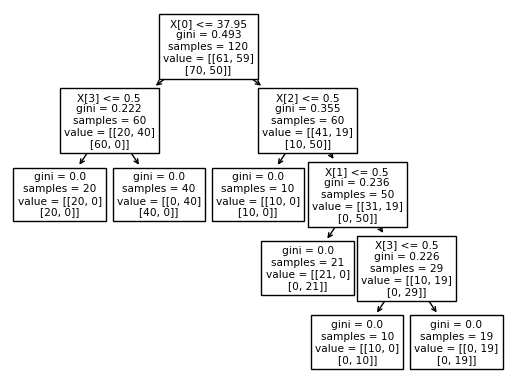

In [272]:
# X -> features, y -> label
X = diagnosis.iloc[:,:6]
y = diagnosis.iloc[:,6:]

# Build decision tree classifier
dt = tree.DecisionTreeClassifier()
dt.fit(X, y)
tree.plot_tree(dt)


#### (c) Convert the decision rules into a set of IF-THEN rules.

In [273]:
def tree_to_pseudo(tree, feature_names):
	"""
	Outputs a decision tree model as if/then pseudocode
	
	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as pseudocode
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	left = tree.tree_.children_left
	right = tree.tree_.children_right
	threshold = tree.tree_.threshold
	features = [feature_names[i] for i in tree.tree_.feature]
	value = tree.tree_.value

	def recurse(left, right, threshold, features, node, depth=0):
		indent = "  " * depth
		if (threshold[node] != -2):
			print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
			if left[node] != -1:
				recurse (left, right, threshold, features, left[node], depth+1)
				print(indent,"} else {")
				if right[node] != -1:
					recurse (left, right, threshold, features, right[node], depth+1)
				print(indent,"}")
		else:
			print(indent,"return " + str(value[node]))

	recurse(left, right, threshold, features, 0)
    
    
tree_to_pseudo(dt, colNames[0:6])

 if ( Temperature <= 37.95000076293945 ) {
   if ( Urine <= 0.5 ) {
     return [[20.  0.]
 [20.  0.]]
   } else {
     return [[ 0. 40.]
 [40.  0.]]
   }
 } else {
   if ( Lumbar <= 0.5 ) {
     return [[10.  0.]
 [10.  0.]]
   } else {
     if ( Nausea <= 0.5 ) {
       return [[21.  0.]
 [ 0. 21.]]
     } else {
       if ( Urine <= 0.5 ) {
         return [[10.  0.]
 [ 0. 10.]]
       } else {
         return [[ 0. 19.]
 [ 0. 19.]]
       }
     }
   }
 }


#### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

In [274]:
train_x, test_x, train_y, test_y = train_test_split(X, y)
# prune the tree with cost complexity pruning — Alpha (from https://vzhang1999.medium.com/classification-tree-growing-and-pruning-with-python-code-grid-search-cost-complexity-function-b2e45e33a1a4)
path = dt.cost_complexity_pruning_path(train_x, train_y)
alphas, impurities = path.ccp_alphas, path.impurities
mean, std = [], []
for i in alphas:
    tree = DecisionTreeClassifier(ccp_alpha=i, random_state=0)
# 5 fold cross validation for each alpha value
    scores = cross_val_score(tree, X, y, cv=5)
    mean.append(scores.mean())
    std.append(scores.std())
# keep a record of the values of alpha, mean accuracy rate, standard deviation of accuracies
eva_df = pd.DataFrame({'alpha': alphas, 'mean': mean, 'std': std})
eva_df = eva_df.sort_values(['mean'], ascending = False)
eva_df.head(10)

,alpha,mean,std
0,0.000000,0.950000,0.100000
1,0.042328,0.758333,0.244949
2,0.060444,0.708333,0.260875
3,0.065827,0.708333,0.260875
4,0.118182,0.541667,0.131762
5,0.210750,0.091667,0.130171


 if ( Temperature <= 37.95000076293945 ) {
   if ( Urine <= 0.5 ) {
     return [[18.  0.]
 [18.  0.]]
   } else {
     return [[ 0. 26.]
 [26.  0.]]
   }
 } else {
   if ( Nausea <= 0.5 ) {
     if ( Urine <= 0.5 ) {
       return [[5. 0.]
 [5. 0.]]
     } else {
       return [[16.  0.]
 [ 0. 16.]]
     }
   } else {
     if ( Urine <= 0.5 ) {
       return [[8. 0.]
 [0. 8.]]
     } else {
       return [[ 0. 17.]
 [ 0. 17.]]
     }
   }
 }


'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        16\n           1       1.00      1.00      1.00         9\n\n   micro avg       1.00      1.00      1.00        25\n   macro avg       1.00      1.00      1.00        25\nweighted avg       1.00      1.00      1.00        25\n samples avg       0.77      0.77      0.77        25\n'

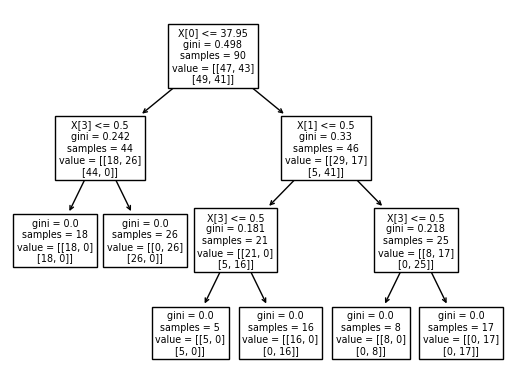

In [275]:
from sklearn import tree
# fit the pruned tree - cv
prunedtree_cv = DecisionTreeClassifier(ccp_alpha=eva_df.iloc[0, 0], random_state=0)
prunedtree_cv.fit(train_x, train_y)
tree.plot_tree(prunedtree_cv)
tree_to_pseudo(prunedtree_cv, colNames[0:6])
classification_report(train_y, prunedtree_cv.predict(train_x))
classification_report(test_y, prunedtree_cv.predict(test_x))

## 2. The LASSO and Boosting for Regression

### (a) Download the Communities and Crime data from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.


In [276]:
parentPath = "../data/"

#get columnnames from names file
colNames = []
file = open(parentPath + "communities.names", "r")
for l in file:
    if l.startswith("@attribute"):
        colNames.append(l.split()[1])

#get data
communitiesData = pd.read_csv(parentPath + "communities.data", header = None, names=colNames)
communitiesData.head()
#trainData = communitiesData.iloc[:1495,:]
#testData = communitiesData.iloc[1495:,:]
communitiesData.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


### (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [277]:
#indices 0-4 are non predictive
communitiesData = communitiesData.iloc[:,5:]
communitiesData = communitiesData.replace("?", np.nan)
communitiesData = communitiesData.apply(pd.to_numeric, errors='ignore')
communitiesData = communitiesData.fillna(value = communitiesData.mean())

# update train/test
trainData = communitiesData.iloc[:1495,:]
testData = communitiesData.iloc[1495:,:]


### (c) Plot a correlation matrix for the features in the data set.

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
population,1.000000,-0.046148,0.231178,-0.300845,0.181603,0.156218,0.006368,0.130344,0.075596,-0.102006,...,0.713652,0.231897,0.270356,0.609147,0.595543,-0.061583,0.076527,0.466352,-0.035576,0.367157
householdsize,-0.046148,1.000000,-0.067109,-0.235907,0.201996,0.468659,0.520461,0.367338,0.295225,-0.612666,...,-0.015078,-0.004072,-0.051506,-0.032663,-0.007584,-0.006426,-0.000280,-0.094368,-0.054562,-0.034923
racepctblack,0.231178,-0.067109,1.000000,-0.794389,-0.106738,-0.066581,0.122338,0.153475,0.134068,0.052934,...,0.149758,0.095053,0.147023,0.122017,0.083179,-0.082660,0.010987,0.260793,0.022237,0.631264
racePctWhite,-0.300845,-0.235907,-0.794389,1.000000,-0.270266,-0.444166,-0.194015,-0.266852,-0.183804,0.136483,...,-0.131389,-0.337458,-0.215636,-0.109191,-0.114860,0.052940,-0.033209,-0.276234,-0.006323,-0.684770
racePctAsian,0.181603,0.201996,-0.106738,-0.270266,1.000000,0.266743,-0.025020,0.100727,0.052761,-0.272020,...,-0.001084,0.389944,0.296921,-0.017992,0.067745,0.032389,0.065424,0.101888,-0.011619,0.037622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LemasPctPolicOnPatr,-0.061583,-0.006426,-0.082660,0.052940,0.032389,0.024366,0.000652,0.013327,0.013687,0.005601,...,-0.067678,0.055734,0.023457,-0.115349,-0.089736,1.000000,0.007179,0.021153,-0.237240,-0.039002
LemasGangUnitDeploy,0.076527,-0.000280,0.010987,-0.033209,0.065424,0.025956,0.011271,0.005145,-0.001001,-0.042756,...,0.109830,-0.076634,-0.082946,0.078436,0.023349,0.007179,1.000000,-0.015712,-0.021100,0.055038
LemasPctOfficDrugUn,0.466352,-0.094368,0.260793,-0.276234,0.101888,0.125353,0.001301,0.117290,0.083180,-0.010168,...,0.299632,0.228084,0.206644,-0.052426,-0.062677,0.021153,-0.015712,1.000000,0.018649,0.348627
PolicBudgPerPop,-0.035576,-0.054562,0.022237,-0.006323,-0.011619,0.002234,-0.076589,-0.068575,-0.049876,0.076586,...,-0.113166,0.067199,0.080024,0.245532,0.259342,-0.237240,-0.021100,0.018649,1.000000,0.045466


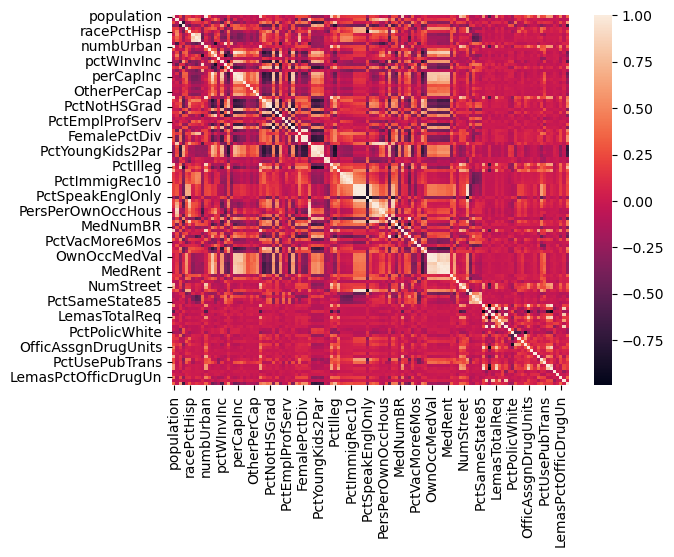

In [278]:
#get correlation matrix
corrM = communitiesData.corr()
display(corrM)
#plot heat map
sns.heatmap(corrM)
plt.show()

### (d) Calculate the Coefficient of Variation CV for each feature, where CV = s/m, in which s is sample standard deviation and m is sample mean.


In [279]:
cvVals = pd.DataFrame({"mean": communitiesData.mean(), "std":communitiesData.std(), "cv": communitiesData.std()/communitiesData.mean() })
display(cvVals)

,mean,std,cv
population,0.057593,0.126906,2.203503
householdsize,0.463395,0.163717,0.353298
racepctblack,0.179629,0.253442,1.410920
racePctWhite,0.753716,0.244039,0.323782
racePctAsian,0.153681,0.208877,1.359162
...,...,...,...
LemasPctPolicOnPatr,0.698589,0.085459,0.122331
LemasGangUnitDeploy,0.440439,0.162099,0.368040
LemasPctOfficDrugUn,0.094052,0.240328,2.555266
PolicBudgPerPop,0.195078,0.065796,0.337281


### (e) Pick √128 features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?


Index(['NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig',
       'LemasPctOfficDrugUn', 'NumUnderPov', 'population', 'numbUrban',
       'HousVacant', 'LandArea', 'racePctHisp'],
      dtype='object')

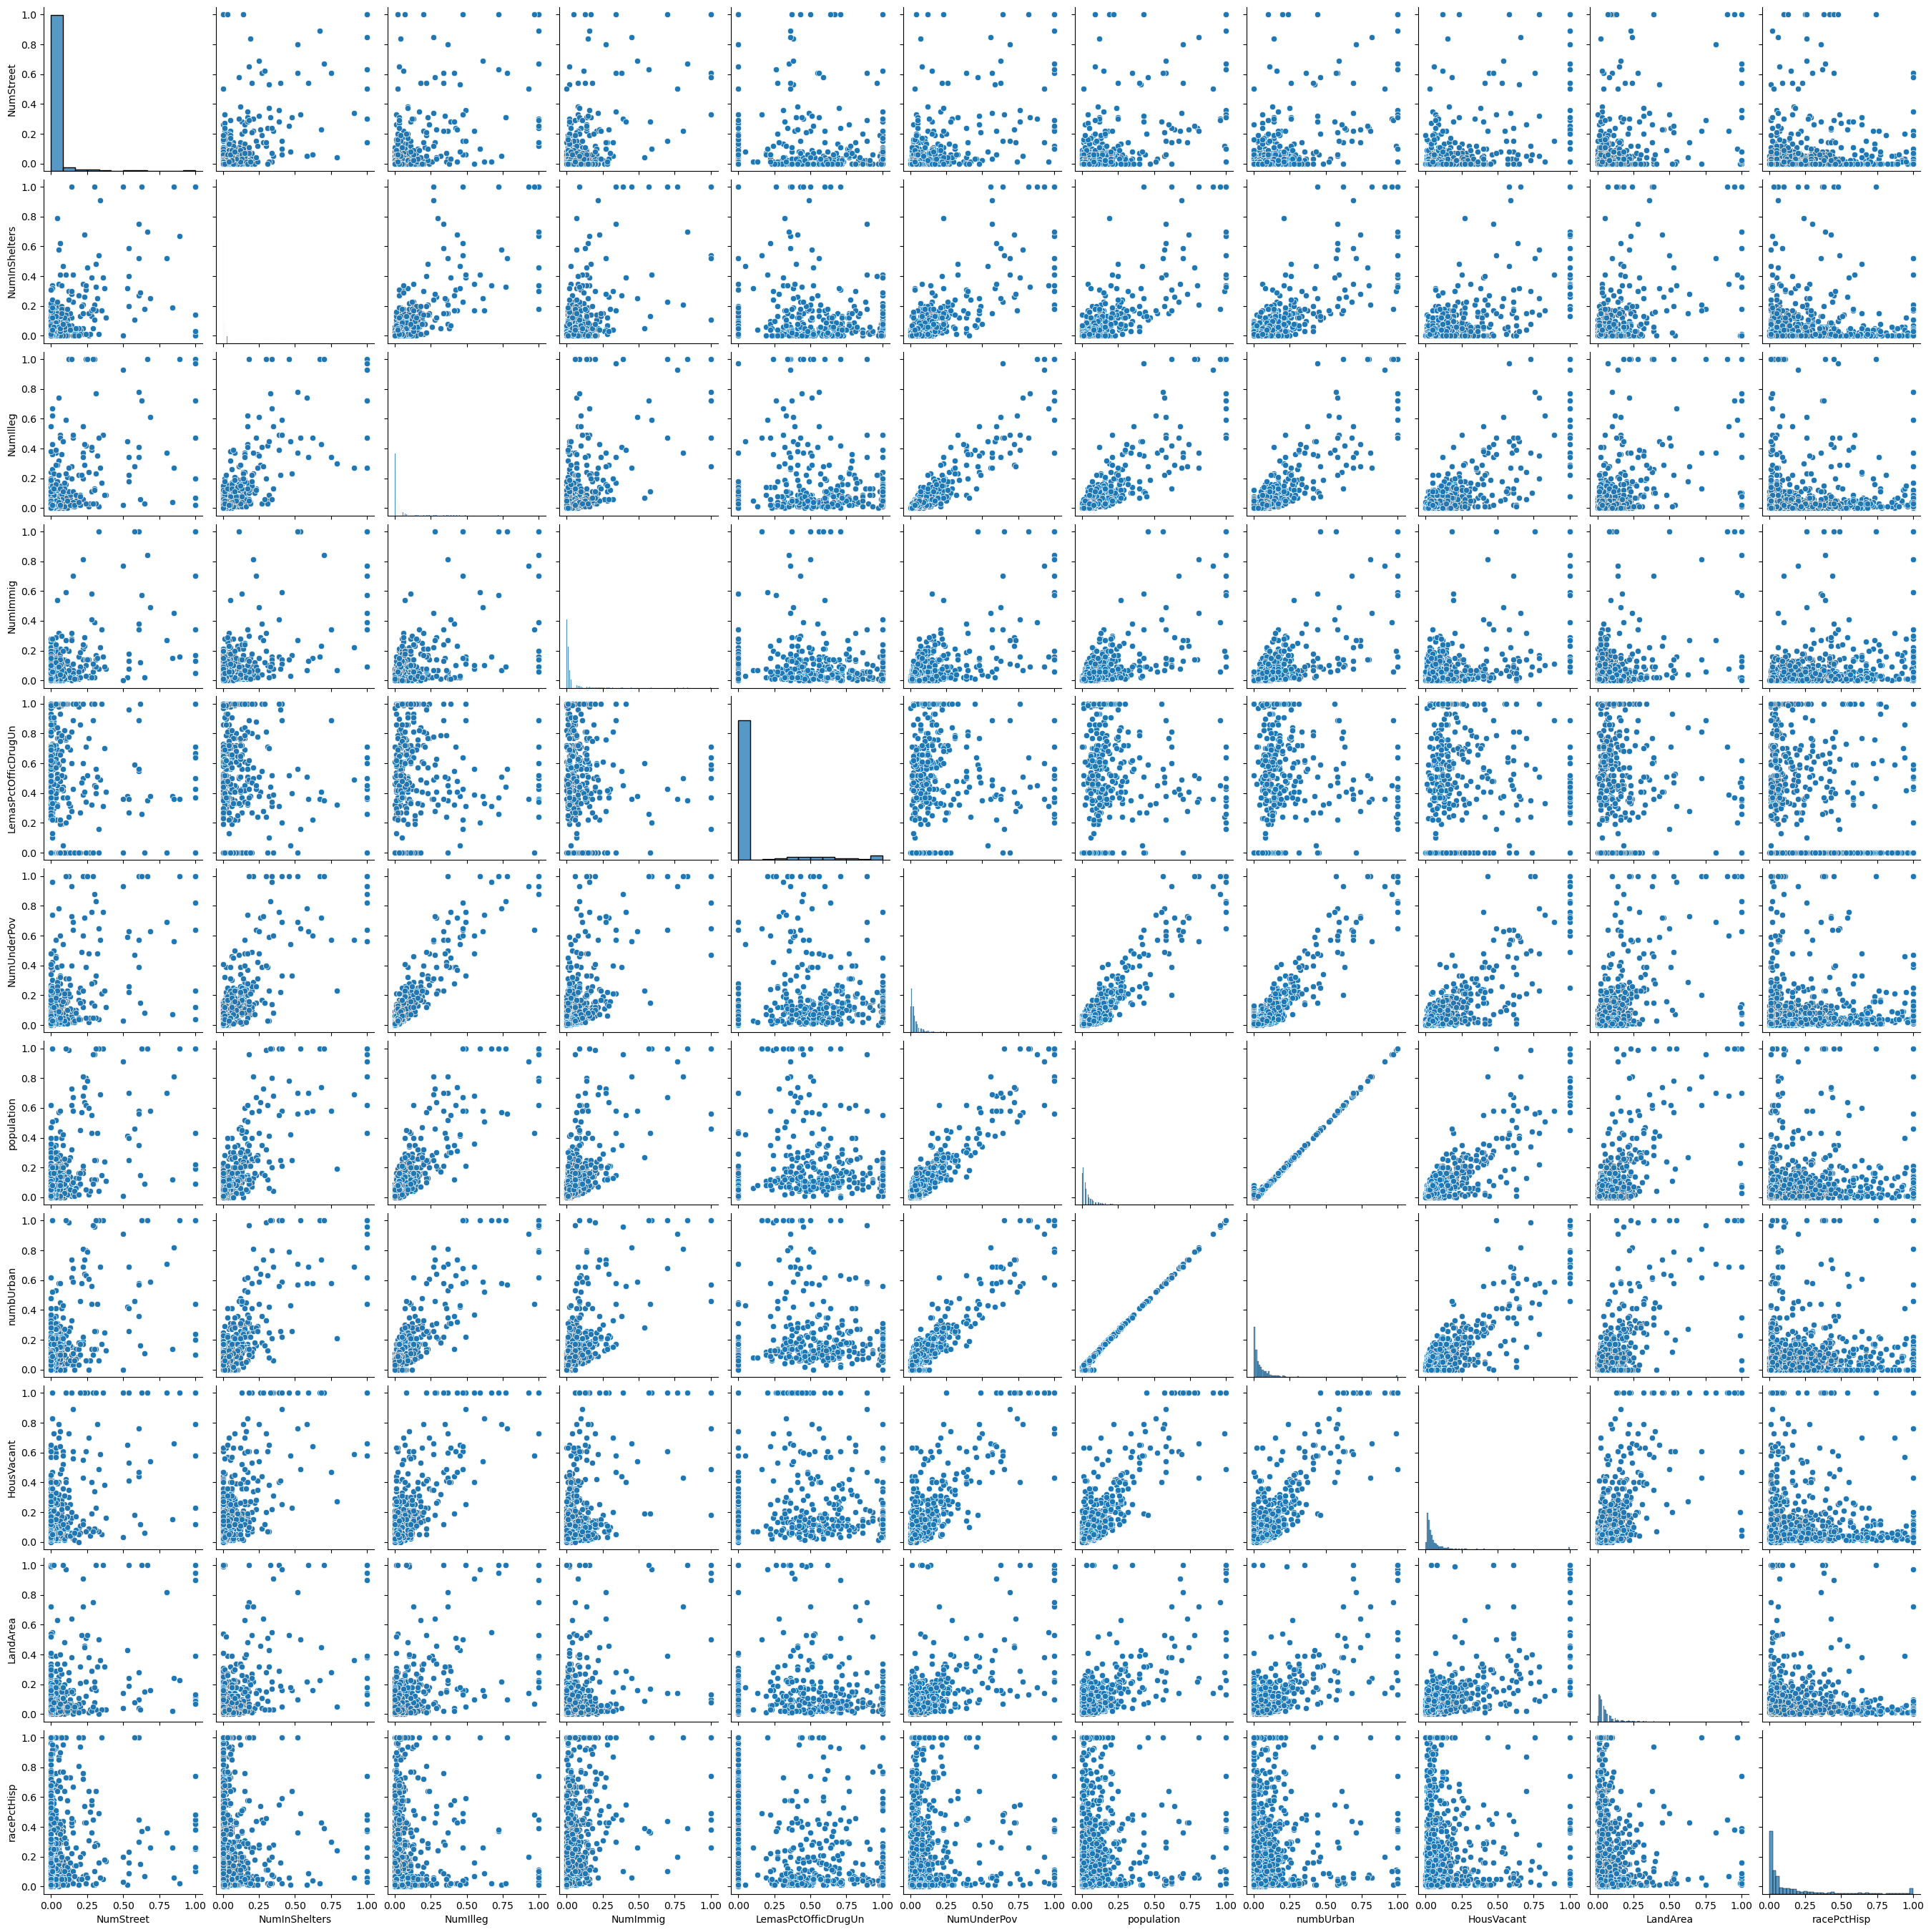

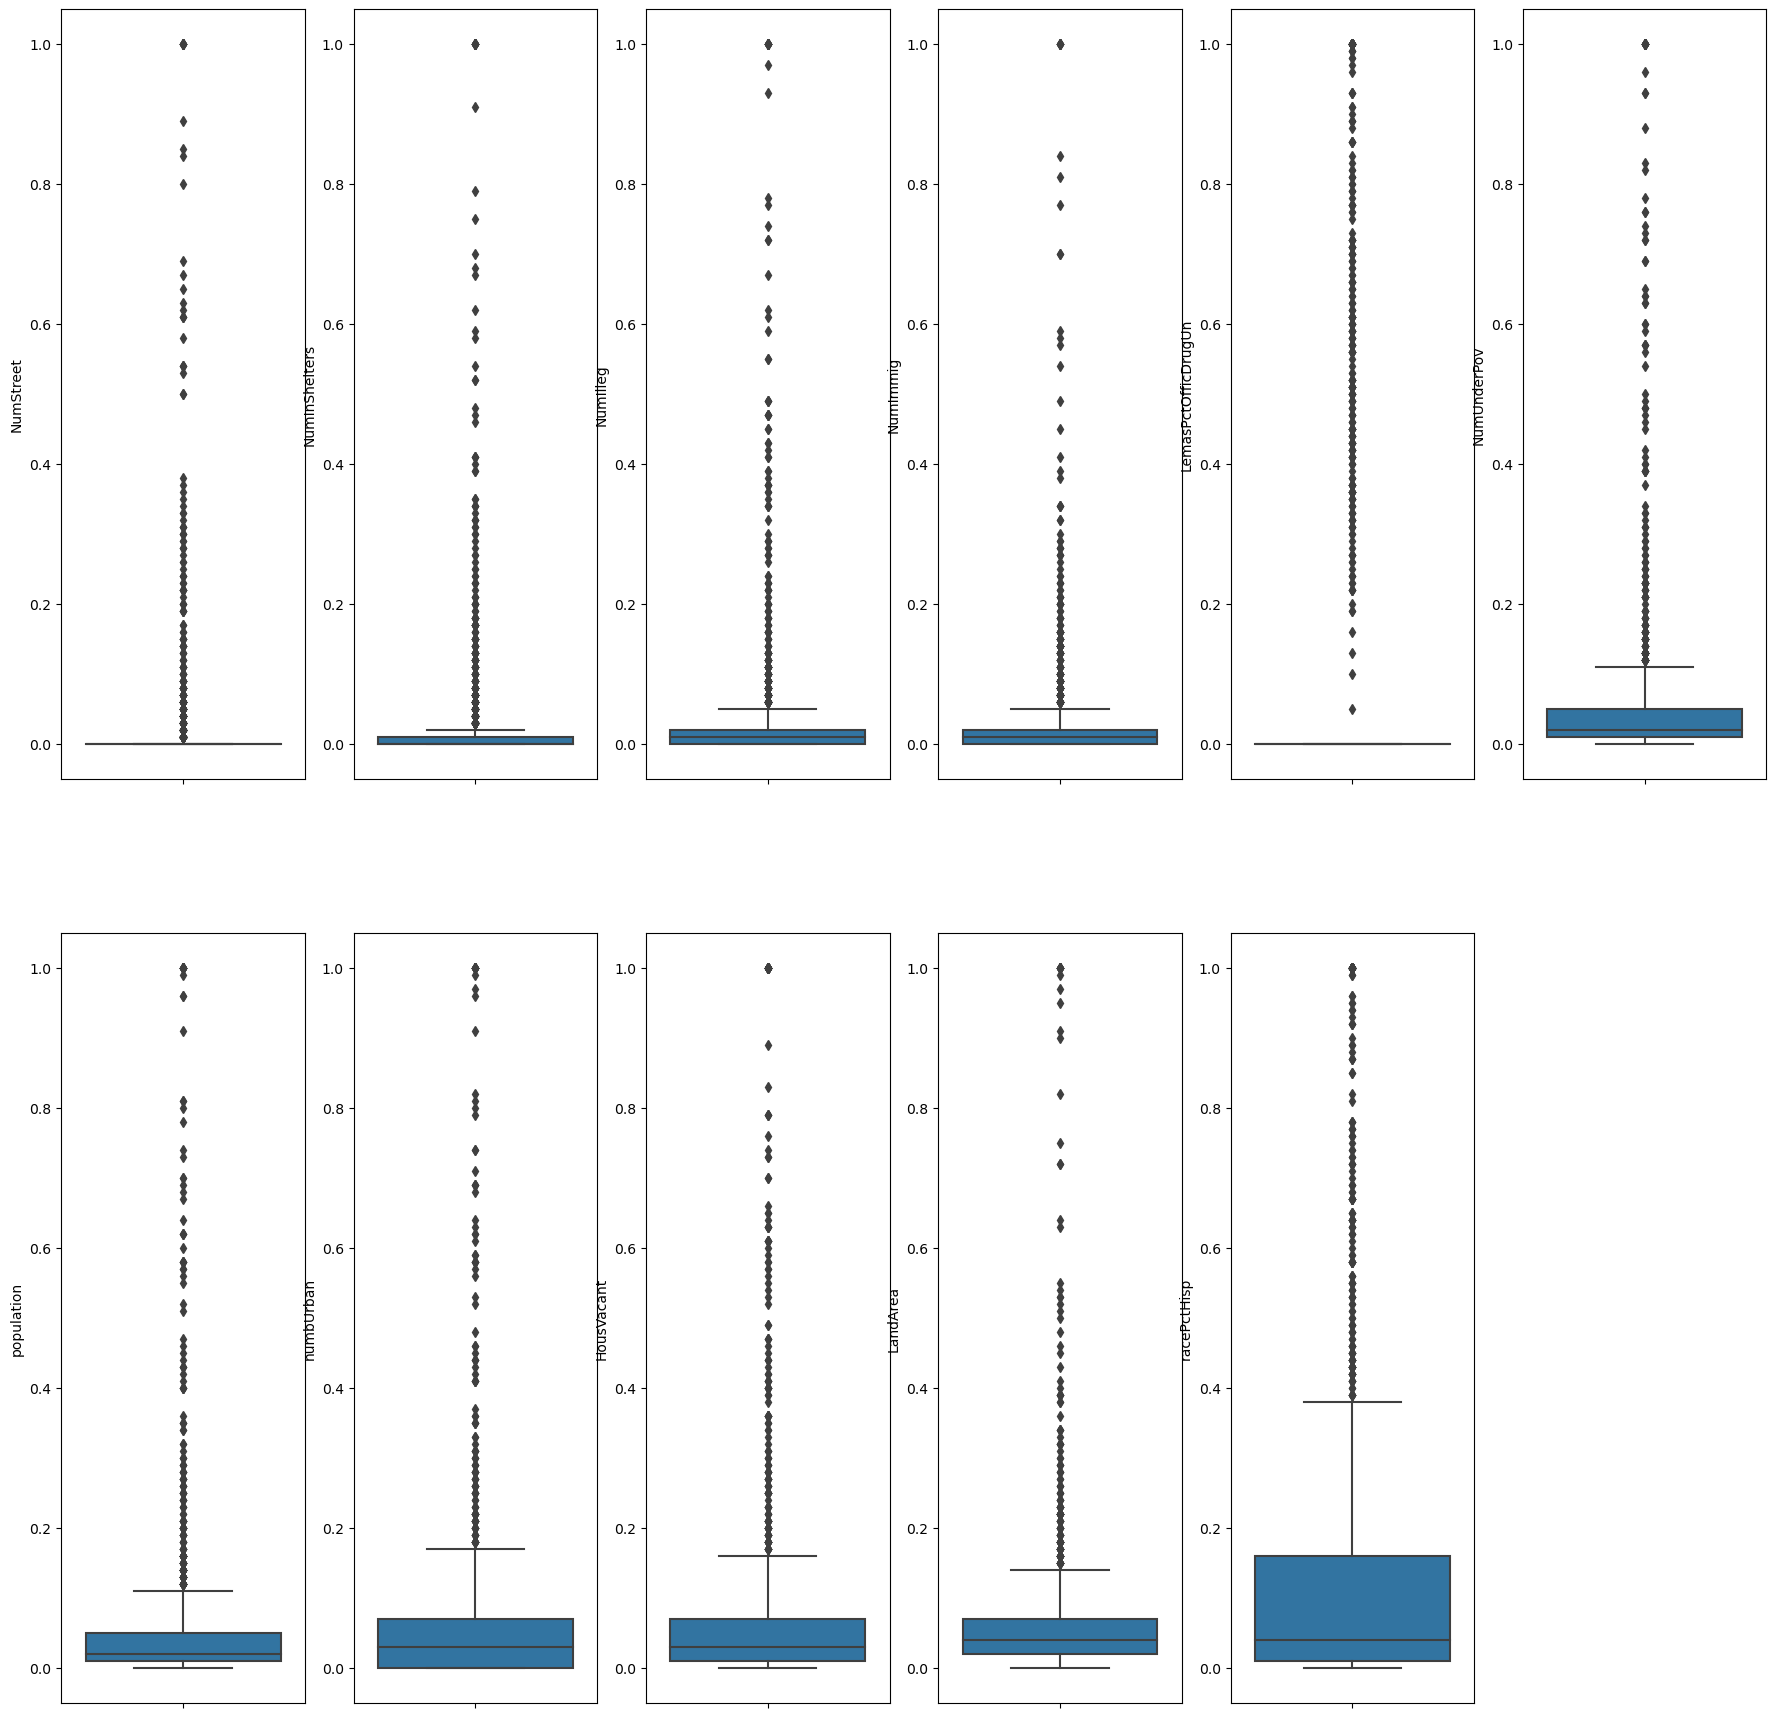

In [280]:
sortedcv = cvVals.sort_values(by=['cv'], ascending=False)
sortedcv = sortedcv.iloc[:(int(math.sqrt(128))),:]
display(sortedcv.index)
topFeatures = communitiesData.loc[:,sortedcv.index]
#scatter plots
sns.pairplot(topFeatures)
plt.show()

#boxplots
plt.figure(figsize=(22,22))
index = 1
for i in range(0, np.shape(topFeatures)[1]):
    plt.subplot(2,6,index)
    sns.boxplot(y = sortedcv.index[i], data = topFeatures)
    index +=1


From the results, it appears "population" and "numbUrban" have a very strong positive correlation with each other.

### (f) Fit a linear model using least squares to the training set and report the test error.

In [281]:
x_train = trainData.iloc[:,:-1]
y_train = trainData.iloc[:,-1]

x_test = testData.iloc[:,:-1]
y_test = testData.iloc[:,-1]

linReg = LinearRegression(fit_intercept=False).fit(x_train, y_train)
y_predict = pd.DataFrame(linReg.predict(x_test))

mse = metrics.mean_squared_error(y_test, y_predict)
print('Test MSE = ', mse)



Test MSE =  0.7811068853925586


### (g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [282]:
# list of alphas to check: 100 values from 0 to 5 with
r_alphas = np.logspace(0, 5, 100)
# initiate the cross validation over alphas
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', normalize=False)
# fit the model with the best alpha
ridge_model = ridge_model.fit(x_train, y_train)
print('The λ value = %f.' %(ridge.alpha_))

ridge = RidgeCV(alphas = 1.0, normalize=False)
ridge.fit(x_train, y_train)
y_predict = ridge.predict(x_test)
mse = metrics.mean_squared_error(y_test, y_predict)

print('For a ridge regression model, the test MSE = %f , with a λ value = %f.' %(mse, ridge.alpha_))

The λ value = 1.000000.
For a ridge regression model, the test MSE = 0.017737 , with a λ value = 1.000000.


### (h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized4 features. Report the test error for both cases and compare them.

In [283]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(x_train, y_train)

# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(x_train, y_train)
mse = mean_squared_error(y_test, lasso_best.predict(x_test))

print('For a LASSO regression model, the test MSE = %f , with a λ value = %f.' %(mse, model.alpha_))
print('The coefficients which were included are all of those with a coefficient != 0, and are listed below:')
coefList = pd.DataFrame(list(zip(lasso_best.coef_, communitiesData)))
coefList = coefList.rename(columns={0: "coeffiencts", 1: "feature"})
coefList = coefList.loc[coefList['coeffiencts'] != 0]

display(coefList)

For a LASSO regression model, the test MSE = 0.017763 , with a λ value = 0.000116.
The coefficients which were included are all of those with a coefficient != 0, and are listed below:


,coeffiencts,feature
2,0.271989,racepctblack
4,-0.015489,racePctAsian
6,0.066307,agePct12t21
7,-0.265008,agePct12t29
11,0.040519,pctUrban
...,...,...
115,-0.043701,PctUsePubTrans
118,0.024092,LemasPctPolicOnPatr
119,0.040526,LemasGangUnitDeploy
120,0.002006,LemasPctOfficDrugUn


In [284]:
# repeat with standardized features
scaler = preprocessing.StandardScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.fit_transform(x_test)

# Lasso with 5 fold cross-validation
model_s = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model_s.fit(x_train_s, y_train)

# Set best alpha
lasso_best_s = Lasso(alpha=model_s.alpha_)
lasso_best_s.fit(x_train_s, y_train)
mse_s = mean_squared_error(y_test, lasso_best_s.predict(x_test_s))

print('For a LASSO regression model with Standardized features, the test MSE = %f , with a λ value = %f.' %(mse_s, model_s.alpha_))
print('The coefficients which were included are all of those with a coefficient != 0, and are listed below:')
coefList_s = pd.DataFrame(list(zip(lasso_best_s.coef_, communitiesData)))
coefList_s = coefList_s.rename(columns={0: "coeffiencts", 1: "feature"})
coefList_s = coefList_s.loc[coefList_s['coeffiencts'] != 0]

display(coefList_s)

For a LASSO regression model with Standardized features, the test MSE = 0.017998 , with a λ value = 0.000763.
The coefficients which were included are all of those with a coefficient != 0, and are listed below:


,coeffiencts,feature
2,0.068260,racepctblack
4,-0.000887,racePctAsian
6,0.010317,agePct12t21
7,-0.038187,agePct12t29
11,0.016597,pctUrban
...,...,...
114,0.003159,PopDens
115,-0.008821,PctUsePubTrans
116,0.004048,PolicCars
118,0.002291,LemasPctPolicOnPatr


The test error in the non-standardized case was MSE = 0.017581 , with a λ value = 0.000108, whereas in the standardized case it was MSE = 0.017740 , with a λ value = 0.000664. The difference is not very large, but the non-standardized case has a slightly lower MSE value. 

### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.

The lowest training error is 0.019543, which corresponds to a value of 95 for M, the number of principal components.

The lowest test error with the same value of M is 0.035067.


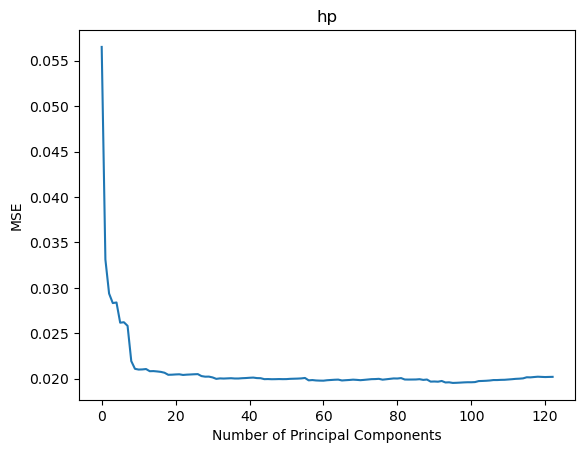

In [285]:
#scale predictor variables
pca = PCA()
X_reduced = pca.fit_transform(scale(x_train))

#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*cross_val_score(regr,
           np.ones((len(X_reduced),1)), y_train, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
num_components = np.arange(1, X_reduced.shape[1] + 1)
for i in num_components:
    score = -1*cross_val_score(regr,
               X_reduced[:,:i], y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('hp')

min_m = mse.index(min(mse))
# get test error
X_reduced_test = pca.fit_transform(scale(x_test))
test_score = -1*cross_val_score(regr,
               X_reduced_test[:,:min_m], y_test, cv=cv, scoring='neg_mean_squared_error').mean()

print("The lowest training error is %f, which corresponds to a value of %d for M, the number of principal components.\n" %(min(mse), min_m))
print("The lowest test error with the same value of M is %f." %(test_score))

### (j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine α (the regularization term) using cross-validation.

In [286]:
scores = []
alphas = np.arange(0,1.1,0.1)
data_dmatrix = xgboost.DMatrix(data=X,label=y, enable_categorical=True)
for a in alphas:
    params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': a}

    cv_results = xgboost.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
    scores.append({"alpha":a, "mse":(cv_results["test-rmse-mean"]).iloc[-1]})

scores = pd.DataFrame(scores)
minVal = scores.iloc[scores[['mse']].idxmin(),:]
print("The lowest test MSE error is %f, which corresponds to a value of %f for alpha.\n" %(minVal["mse"],  minVal["alpha"]))

The lowest test MSE error is 0.209617, which corresponds to a value of 0.200000 for alpha.



# References

https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html <br>
https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/ <br>
https://stackoverflow.com/questions/31700691/convert-commas-decimal-separators-to-dots-within-a-dataframe <br>
https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html <br>
https://www.geeksforgeeks.org/how-to-create-a-correlation-matrix-using-pandas/ <br>
https://towardsdatascience.com/the-power-of-ridge-regression-4281852a64d6 <br>
https://www.kirenz.com/post/2019-08-12-python-lasso-regression-auto/ <br>
https://www.statology.org/principal-components-regression-in-python/ <br>
https://stats.stackexchange.com/questions/84012/choosing-optimal-alpha-in-elastic-net-logistic-regression <br>
https://www.datacamp.com/tutorial/xgboost-in-python <br>


